#START THE PROJECT






In [6]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/PAIA/SkyDefender
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/PAIA/SkyDefender'
/content/drive/MyDrive/PAIA/SkyDefender
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!ls

data  kaggle.json  notebooks


#DOWNLOAD THE DATA

In [ ]:
TRUE_CONDITIONS = ['y', 'yes']


# Download the dataset
delete_temp = input('\tYes(Y)/No(N): ')

if delete_temp.lower() in TRUE_CONDITIONS:
    #! mkdir ./download
    #! kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset -p ./download
    # Unzip the dataset
    !mkdir -p ./data/raw
    !mkdir -p ./data/interim
    !unzip -j ./download/militaryaircraftdetectiondataset.zip "dataset/*" -d ./data/raw
    # Remove temporal files?
    !rm -rf ./download

Streaming output truncated to the last 5000 lines.
  inflating: ../data/raw/c786c6b8439139555fb77ce3855c83ea.csv  
  inflating: ../data/raw/c786c6b8439139555fb77ce3855c83ea.jpg  
  inflating: ../data/raw/c7897db850df4f162c38cb72edb80832.csv  
  inflating: ../data/raw/c7897db850df4f162c38cb72edb80832.jpg  
  inflating: ../data/raw/c78f7f3e6d6efab9d7df0364a44b5159.csv  
  inflating: ../data/raw/c78f7f3e6d6efab9d7df0364a44b5159.jpg  
  inflating: ../data/raw/c79506ac29b1fe1feab6a2011962eb78.csv  
  inflating: ../data/raw/c79506ac29b1fe1feab6a2011962eb78.jpg  
  inflating: ../data/raw/c79b24f53bf8c0f6d63848090da70e8f.csv  
  inflating: ../data/raw/c79b24f53bf8c0f6d63848090da70e8f.jpg  
  inflating: ../data/raw/c7a8a8bdb2a2b4e0b638c0cad3827b97.csv  
  inflating: ../data/raw/c7a8a8bdb2a2b4e0b638c0cad3827b97.jpg  
  inflating: ../data/raw/c7a9fb86570f625ddce0a0c8d80b7626.csv  
  inflating: ../data/raw/c7a9fb86570f625ddce0a0c8d80b7626.jpg  
  inflating: ../data/raw/c7b8e91eb28700c9130dc8c90ee4

In [ ]:
!ls -l ./download

ls: cannot access './download': No such file or directory


In [ ]:
!ls -l ./data/raw

Streaming output truncated to the last 5000 lines.
-rw------- 1 root root      116 May 12 09:13 c786c6b8439139555fb77ce3855c83ea.csv
-rw------- 1 root root  7169777 May 12 09:13 c786c6b8439139555fb77ce3855c83ea.jpg
-rw------- 1 root root      245 May 12 09:13 c7897db850df4f162c38cb72edb80832.csv
-rw------- 1 root root   668426 May 12 09:13 c7897db850df4f162c38cb72edb80832.jpg
-rw------- 1 root root      114 May 12 09:13 c78f7f3e6d6efab9d7df0364a44b5159.csv
-rw------- 1 root root   264987 May 12 09:13 c78f7f3e6d6efab9d7df0364a44b5159.jpg
-rw------- 1 root root      183 May 12 09:13 c79506ac29b1fe1feab6a2011962eb78.csv
-rw------- 1 root root   983154 May 12 09:13 c79506ac29b1fe1feab6a2011962eb78.jpg
-rw------- 1 root root      108 May 12 09:13 c79b24f53bf8c0f6d63848090da70e8f.csv
-rw------- 1 root root    24344 May 12 09:13 c79b24f53bf8c0f6d63848090da70e8f.jpg
-rw------- 1 root root      114 May 12 09:13 c7a8a8bdb2a2b4e0b638c0cad3827b97.csv
-rw------- 1 root root    56336 May 12 09:13 c7

#USING THE DATA

##UNDERSTANDING THE DATASET

In [8]:
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [10]:
csv_path = "./data/raw/"
df = pd.concat([pd.read_csv(csv_path + f, delimiter=',') for f in os.listdir(csv_path) if f.endswith('.csv')], ignore_index=True)

OSError: ignored

In [32]:
df.to_csv('./data/interim/merged_info.csv', index=False)

In [33]:
if df.isnull().values.any():
    print("There are null values in DF")
else:
    print("No null values in DF.")

No null values in DF.


In [34]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,f771361bbad61edd7843923339718cfc,1199,900,V22,57,586,210,628
1,f78e719a2202980b03d34e8dac74dc8b,900,600,US2,350,269,628,377
2,f775965fef62fc862be7adfd5ac95f56,2889,1744,JAS39,2063,525,2686,738
3,f7794fc3856dac21fe9a22860ff264cf,1170,763,Tornado,161,237,496,369
4,f7794fc3856dac21fe9a22860ff264cf,1170,763,Tornado,28,149,1130,577


<Axes: ylabel='class'>

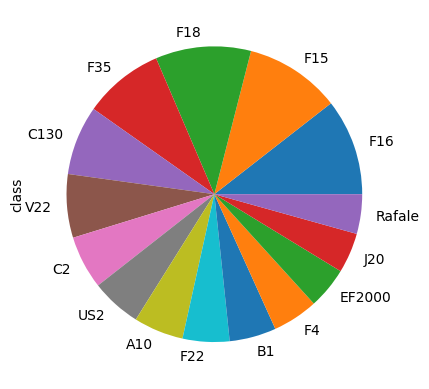

In [35]:
df["class"].value_counts().head(15).plot(kind="pie") #See where can we reduce a bit our dataset

Reduced from 17834 rows to 3139 rows


<Axes: ylabel='class'>

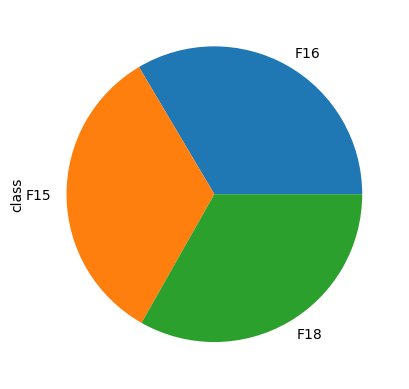

In [36]:
target = ["F16", "F15", "F18"] #Classes we want to keep

df_reduced = df.loc[df["class"].isin(target)].copy(deep=True)

print(f"Reduced from {len(df.index)} rows to {len(df_reduced.index)} rows")
df_reduced["class"].value_counts().plot(kind="pie")

In [37]:
# Image location
images_dir = './data/raw/'

df_clean = df_reduced.copy(deep = True)

# Add the filepath to the image into the dataframe
df_clean['filepath'] = images_dir + df['filename'] + '.jpg'
df_clean.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,filepath
12,f71a46b53574c93786dbc22b2da21736,3000,1995,F16,1,338,3000,1612,./data/raw/f71a46b53574c93786dbc22b2da21736.jpg
20,f732d92d31c8713ab68c37277326c192,1800,1200,F15,544,359,978,456,./data/raw/f732d92d31c8713ab68c37277326c192.jpg
25,f772ad8fe3eb0347797d2631c398c379,1000,667,F16,535,349,618,377,./data/raw/f772ad8fe3eb0347797d2631c398c379.jpg
26,f772ad8fe3eb0347797d2631c398c379,1000,667,F16,666,381,748,410,./data/raw/f772ad8fe3eb0347797d2631c398c379.jpg
27,f772ad8fe3eb0347797d2631c398c379,1000,667,F16,782,409,863,439,./data/raw/f772ad8fe3eb0347797d2631c398c379.jpg


In [38]:
df_img = df_clean.copy(deep = True)
height = 256
width = 256
# Iteración sobre el dataframe
for index, row in df_clean.iterrows():
    # Leer la ruta de la imagen del dataframe
    filepath = row['filepath']
    
    # Cargar la imagen utilizando TensorFlow
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=(height, width))  # Ajusta height y width a tus dimensiones deseadas
    
    # Convertir la imagen a un arreglo numpy
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Normalizar los valores de píxel a un rango entre 0 y 1
    img_array /= 255.0
    
    # Calcular las coordenadas normalizadas
    x_min = row['xmin'] / width
    y_min = row['ymin'] / height
    x_max = row['xmax'] / width
    y_max = row['ymax'] / height
    
    # Obtener la etiqueta de clase
    label = row['class']
    
    # Guardar las coordenadas normalizadas y la etiqueta en el dataframe
    df_img.at[index, 'x_min_norm'] = x_min
    df_img.at[index, 'y_min_norm'] = y_min
    df_img.at[index, 'x_max_norm'] = x_max
    df_img.at[index, 'y_max_norm'] = y_max
    df_img.at[index, 'label'] = label

FileNotFoundError: ignored

In [ ]:
image = keras.utils.load_img("./data/raw/627336ac6a53a9e90a71ccd9f95294c1.jpg")

In [ ]:
image

##TRAIN/TEST SEPARATION

In [ ]:
#Create Train and Test sets
train_dfs = []
test_dfs = []

grouped = df_clean.groupby('class') 

for category, group_df in grouped:
    # Divide the sets
    train_df, test_df = train_test_split(group_df, test_size=0.2, random_state=42) #For each group, we set an 80% train 20%test
    train_dfs.append(train_df)
    test_dfs.append(test_df)

In [ ]:
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

In [ ]:
print(test_df.head())
print("------------------------")
print("Total: " + str(len(test_df)))

In [ ]:
print(train_df.head())
print("------------------------")
print("Total: "+ str(len(train_df)))